Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model

Load dataset and prepare df

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df = df.groupby(date_column).sum().reset_index()
df.set_index(date_column, inplace=True)
df = df.dropna()
dates = df.index.values

Train test split

In [3]:
data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

Parameter tuning for order

In [4]:
stepwise_fit = auto_arima(df[target_column], trace=True, suppress_warnings=True)
best_order = stepwise_fit.order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=25434.630, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26399.060, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26046.009, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25529.861, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26397.060, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=25372.067, Time=1.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=25532.960, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25527.504, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=25397.134, Time=0.77 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=25394.082, Time=0.52 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=25509.372, Time=0.39 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=25322.892, Time=1.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=25190.587, Time=1.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=25328.345, Time=0.92 sec
 ARIMA(4,1,3)(0,0,0

In [5]:
print(best_order)

(3, 1, 3)


Create Model

In [6]:
model = ARIMA(train[target_column], order=best_order)
model = model.fit()
model.summary()

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/samuell/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             New_deaths   No. Observations:                 1251
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -11389.714
Date:                Sat, 13 Apr 2024   AIC                          22793.427
Time:                        20:42:34   BIC                          22829.343
Sample:                    02-02-2020   HQIC                         22806.929
                         - 07-06-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9303      0.033    -28.225      0.000      -0.995      -0.866
ar.L2         -0.9653      0.034    -28.524      0.000      -1.032      -0.899
ar.L3         -0.3451      0.025    -13.638      0.000      -0.395      -0.296
ma.L1          0.0811      0.022      3.637      0.000       0.037       0.125
ma.L2          0.1216      0.023      5.211      0.000       0.076       0.167
ma.L3         -0.7641      0.021    -37.064      0.000      -0.805      -0.724
sigma2      4.797e+06    1.1e+05     43.683      0.000    4.58e+06    5.01e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):              3998.68
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             1.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, typ="levels")

In [ ]:
non_zero = []
 
for i in pred:
    removed_initial_one = i-1
    if removed_initial_one == 0:
        non_zero.append(removed_initial_one+sys.float_info.min)
    else:
        non_zero.append(removed_initial_one)

Plot the result

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


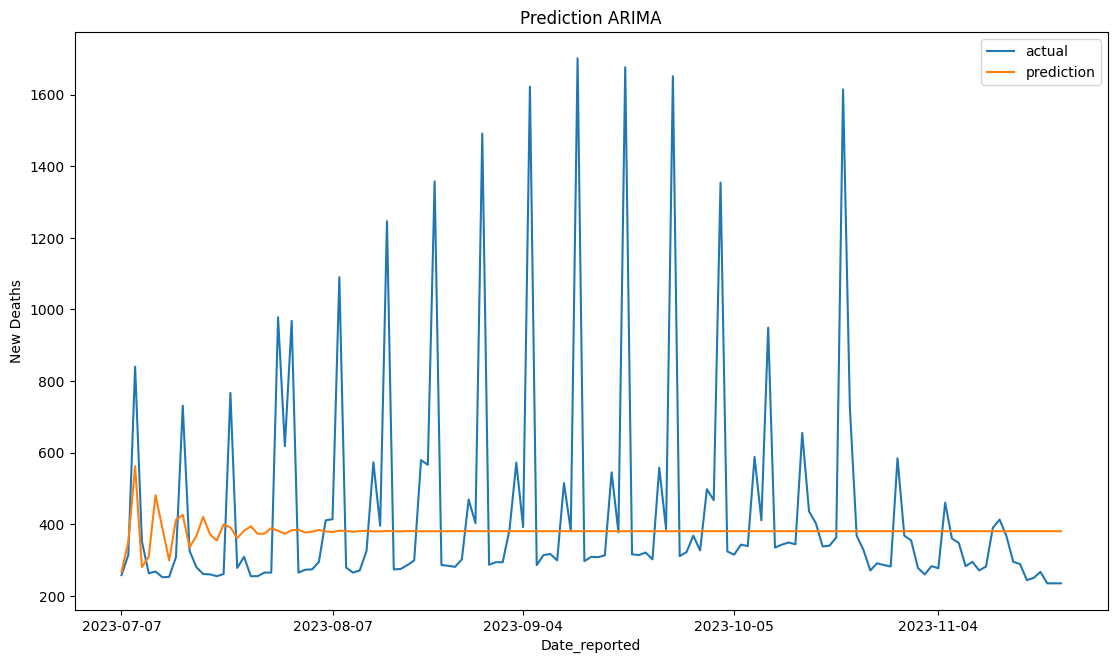

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(dates[int(data_length*train_split):], (test[target_column]-1).values, label="actual")
ax.plot(dates[int(data_length*train_split):], non_zero, label="prediction")
ax.set_title("Prediction ARIMA")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

RMSE of the result

In [38]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from typing import Dict
import numpy as np

from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError

def evaluate_forecast(predictions: pd.Series, actuals: pd.Series, train = None) -> Dict[str, float]:
    """
    Evaluate time series forecast using various metrics.

    Parameters:
    - predictions (pd.Series): The predicted values.
    - actuals (pd.Series): The actual values.

    Returns:
    - Dict[str, float]: A dictionary containing various evaluation metrics.
    """
    metrics = {}

    # MSE
    metrics["MSE"] = mean_squared_error(actuals, predictions)

    # RMSE
    metrics["RMSE"] = np.sqrt(metrics["MSE"])

    # MAE
    metrics["MAE"] = mean_absolute_error(actuals, predictions)

    # MAPE
    metrics["MAPE"] = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    # SMAPE
    metrics["SMAPE"] = round(
        np.mean(
            np.abs(predictions - actuals)
            / ((np.abs(predictions) + np.abs(actuals)) / 2)
        )
        * 100,
        2,
    )

    # MASE
    mase = MeanAbsoluteScaledError()

    metrics["MASE"] = mase(np.array(predictions), np.array(actuals), y_train=np.array(train))

    
    return metrics


def print_evaluation_metrics(predictions: pd.Series, actuals: pd.Series, train = None):
    """
    Print the evaluation metrics in a formatted manner.

    Parameters:
    - predictions (pd.Series): The predicted values.
    - actuals (pd.Series): The actual values.
    """
    metrics = evaluate_forecast(predictions, actuals, train)
    print("Evaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")


In [39]:
print_evaluation_metrics(non_zero, test[target_column]-1, train[target_column]-1)

Evaluation Metrics:
MSE: 109245.46
RMSE: 330.52
MAE: 176.31
MAPE: 31.14
SMAPE: 32.80
MASE: 0.10


In [9]:
store_model(model, "arima")